#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

print("Libraries imported successfully!")

Libraries imported successfully!


#### Generate Data

In [2]:
np.random.seed(42)  # For reproducibility

# Parameters
N = 10000
p0 = 0.65
p1 = 0.35

u = np.random.rand(N) >= p0
N0 = np.sum(u == 0)
N1 = np.sum(u == 1)

print(f"Total samples: {N}")
print(f"Class 0 samples: {N0} ({N0/N*100:.2f}%)")
print(f"Class 1 samples: {N1} ({N1/N*100:.2f}%)")

m0 = np.array([-1/2, -1/2, -1/2])
C0 = np.array([[1, -0.5, 0.3],
               [-0.5, 1, -0.5],
               [0.3, -0.5, 1]])

m1 = np.array([1, 1, 1])
C1 = np.array([[1, 0.3, -0.2],
               [0.3, 1, 0.3],
               [-0.2, 0.3, 1]])

r0 = np.random.multivariate_normal(m0, C0, N0)
r1 = np.random.multivariate_normal(m1, C1, N1)

X = np.vstack([r0, r1])
labels = np.hstack([np.zeros(N0), np.ones(N1)])

print(f"\nData shape: {X.shape}")
print(f"Labels shape: {labels.shape}")


Total samples: 10000
Class 0 samples: 6603 (66.03%)
Class 1 samples: 3397 (33.97%)

Data shape: (10000, 3)
Labels shape: (10000,)


#### Visualize the Data

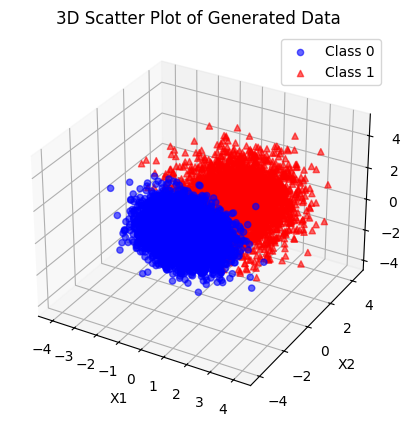

In [26]:
fig = plt.figure(figsize=(8, 5))

# 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(r0[:, 0], r0[:, 1], r0[:, 2], c='blue', marker='o', 
           alpha=0.6, s=20, label='Class 0')
ax1.scatter(r1[:, 0], r1[:, 1], r1[:, 2], c='red', marker='^', 
           alpha=0.6, s=20, label='Class 1')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('X3')
ax1.set_title('3D Scatter Plot of Generated Data')
ax1.legend()


plt.tight_layout()
plt.show()

#### Part A - Step 1 - Derive ERM Classification Rule

In [4]:

gamma_optimal = p0 / p1
print(f"Theoretical optimal threshold: γ* = {gamma_optimal:.4f}")

Theoretical optimal threshold: γ* = 1.8571


#### Step 2 - Compute Likelihood Ratios

In [5]:
dist0 = multivariate_normal(mean=m0, cov=C0)
dist1 = multivariate_normal(mean=m1, cov=C1)

likelihood_0 = dist0.pdf(X)
likelihood_1 = dist1.pdf(X)

# likelihood ratio
epsilon = 1e-300
likelihood_ratio = likelihood_1 / (likelihood_0 + epsilon)

print(f"Likelihood ratio range: [{np.min(likelihood_ratio):.6f}, {np.max(likelihood_ratio):.6f}]")
print(f"Median likelihood ratio: {np.median(likelihood_ratio):.6f}")


Likelihood ratio range: [0.000000, 198683951082335993856.000000]
Median likelihood ratio: 0.113604


#### Step 2 - Generate ROC Curve

In [6]:
gamma_values = np.logspace(-3, 3, 1000) 
gamma_values = np.concatenate([[0], gamma_values, [np.inf]])

# ROC curve points
TPR_values = []  
FPR_values = []  

for gamma in gamma_values:
    decisions = (likelihood_ratio > gamma).astype(int)
    
    # Confusion matrix elements
    TP = np.sum((labels == 1) & (decisions == 1))

    FP = np.sum((labels == 0) & (decisions == 1))
 
    TN = np.sum((labels == 0) & (decisions == 0))

    FN = np.sum((labels == 1) & (decisions == 0))
    

    TPR = TP / N1 if N1 > 0 else 0  
    FPR = FP / N0 if N0 > 0 else 0  
    
    TPR_values.append(TPR)
    FPR_values.append(FPR)

TPR_values = np.array(TPR_values)
FPR_values = np.array(FPR_values)

print(f"ROC curve computed with {len(gamma_values)} threshold values")
print(f"TPR range: [{np.min(TPR_values):.4f}, {np.max(TPR_values):.4f}]")
print(f"FPR range: [{np.min(FPR_values):.4f}, {np.max(FPR_values):.4f}]")

ROC curve computed with 1002 threshold values
TPR range: [0.0000, 1.0000]
FPR range: [0.0000, 1.0000]


#### Step 3 - Find Minimum P(error) Operating Point

In [7]:
# P(error)
FNR_values = 1 - TPR_values 
P_error_values = FPR_values * p0 + FNR_values * p1

# Find minimum P(error)
min_error_idx = np.argmin(P_error_values)
min_P_error = P_error_values[min_error_idx]
optimal_gamma_empirical = gamma_values[min_error_idx]
optimal_TPR = TPR_values[min_error_idx]
optimal_FPR = FPR_values[min_error_idx]

print(f"Minimum P(error): {min_P_error:.4f}")
print(f"Empirical optimal threshold: γ = {optimal_gamma_empirical:.4f}")
print(f"Theoretical optimal threshold: γ* = {gamma_optimal:.4f}")
print(f"Difference: {abs(optimal_gamma_empirical - gamma_optimal):.4f}")
print(f"\nAt optimal operating point:")
print(f"  TPR (True Positive Rate): {optimal_TPR:.4f}")
print(f"  FPR (False Positive Rate): {optimal_FPR:.4f}")
print(f"  TNR (True Negative Rate): {1-optimal_FPR:.4f}")
print(f"  FNR (False Negative Rate): {1-optimal_TPR:.4f}")

Minimum P(error): 0.0565
Empirical optimal threshold: γ = 1.7508
Theoretical optimal threshold: γ* = 1.8571
Difference: 0.1063

At optimal operating point:
  TPR (True Positive Rate): 0.8931
  FPR (False Positive Rate): 0.0294
  TNR (True Negative Rate): 0.9706
  FNR (False Negative Rate): 0.1069


#### Plot ROC Curve

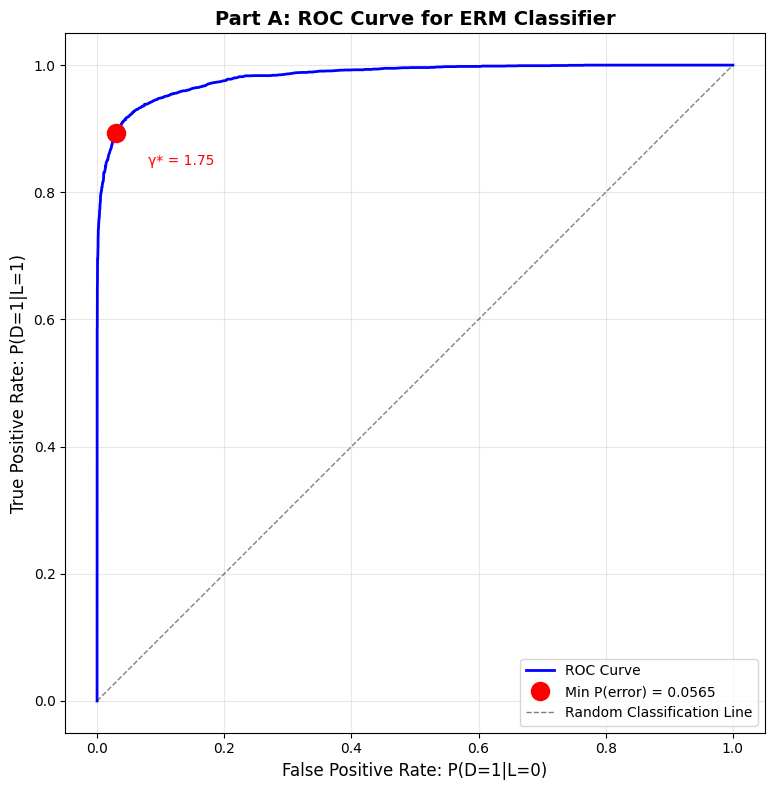

In [20]:
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(FPR_values, TPR_values, 'b-', linewidth=2, label='ROC Curve')

# Minimum P(error) point
plt.plot(optimal_FPR, optimal_TPR, 'ro', markersize=12, 
         markerfacecolor='red', markeredgewidth=2,
         label=f'Min P(error) = {min_P_error:.4f}')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classification Line')

plt.xlabel('False Positive Rate: P(D=1|L=0)', fontsize=12)
plt.ylabel('True Positive Rate: P(D=1|L=1)', fontsize=12)
plt.title('Part A: ROC Curve for ERM Classifier', 
          fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.gca().set_aspect('equal')

plt.text(optimal_FPR + 0.05, optimal_TPR - 0.05, 
         f'γ* = {optimal_gamma_empirical:.2f}',
         fontsize=10, color='red')

plt.tight_layout()
plt.show()

#### Summary and Confusion Matrix

In [9]:
decisions_optimal = (likelihood_ratio > optimal_gamma_empirical).astype(int)

# Compute confusion matrix
TP = np.sum((labels == 1) & (decisions_optimal == 1))
FP = np.sum((labels == 0) & (decisions_optimal == 1))
TN = np.sum((labels == 0) & (decisions_optimal == 0))
FN = np.sum((labels == 1) & (decisions_optimal == 0))

print(f"\nConfusion Matrix at Optimal Threshold (γ = {optimal_gamma_empirical:.4f}):")
print("\n              Predicted")
print("              D=0    D=1")
print(f"Actual  L=0  {TN:4d}   {FP:4d}   (Total: {TN+FP})")
print(f"        L=1  {FN:4d}   {TP:4d}   (Total: {FN+TP})")

print(f"\nConditional Probabilities:")
print(f"  P(D=0|L=0) = {TN/N0:.4f}  (True Negative Rate)")
print(f"  P(D=1|L=0) = {FP/N0:.4f}  (False Positive Rate)")
print(f"  P(D=0|L=1) = {FN/N1:.4f}  (False Negative Rate)")
print(f"  P(D=1|L=1) = {TP/N1:.4f}  (True Positive Rate)")

print(f"\nOverall Performance:")
print(f"  Accuracy: {(TP+TN)/N:.4f}")
print(f"  P(error): {(FP+FN)/N:.4f}")

print(f"\nComparison:")
print(f"  Theoretical γ*: {gamma_optimal:.4f}")
print(f"  Empirical γ:    {optimal_gamma_empirical:.4f}")
print(f"  Match: {'Excellent' if abs(optimal_gamma_empirical - gamma_optimal) < 0.1 else 'Good'}")


Confusion Matrix at Optimal Threshold (γ = 1.7508):

              Predicted
              D=0    D=1
Actual  L=0  6409    194   (Total: 6603)
        L=1   363   3034   (Total: 3397)

Conditional Probabilities:
  P(D=0|L=0) = 0.9706  (True Negative Rate)
  P(D=1|L=0) = 0.0294  (False Positive Rate)
  P(D=0|L=1) = 0.1069  (False Negative Rate)
  P(D=1|L=1) = 0.8931  (True Positive Rate)

Overall Performance:
  Accuracy: 0.9443
  P(error): 0.0557

Comparison:
  Theoretical γ*: 1.8571
  Empirical γ:    1.7508
  Match: Good


#### Part B - Naive Bayes Classifier

In [10]:
C0_NB = np.eye(3)
C1_NB = np.eye(3)

dist0_NB = multivariate_normal(mean=m0, cov=C0_NB)
dist1_NB = multivariate_normal(mean=m1, cov=C1_NB)

likelihood_0_NB = dist0_NB.pdf(X)
likelihood_1_NB = dist1_NB.pdf(X)
likelihood_ratio_NB = likelihood_1_NB / (likelihood_0_NB + epsilon)

print(f"NB Likelihood ratio range: [{np.min(likelihood_ratio_NB):.6f}, {np.max(likelihood_ratio_NB):.6f}]")

NB Likelihood ratio range: [0.000015, 1163311.129304]


#### Generate ROC Curve for NB

In [11]:

TPR_values_NB = []
FPR_values_NB = []

for gamma in gamma_values:
    decisions_NB = (likelihood_ratio_NB > gamma).astype(int)
    
    TP = np.sum((labels == 1) & (decisions_NB == 1))
    FP = np.sum((labels == 0) & (decisions_NB == 1))
    
    TPR_NB = TP / N1 if N1 > 0 else 0
    FPR_NB = FP / N0 if N0 > 0 else 0
    
    TPR_values_NB.append(TPR_NB)
    FPR_values_NB.append(FPR_NB)

TPR_values_NB = np.array(TPR_values_NB)
FPR_values_NB = np.array(FPR_values_NB)

# Find minimum P(error) for NB
FNR_values_NB = 1 - TPR_values_NB
P_error_values_NB = FPR_values_NB * p0 + FNR_values_NB * p1

min_error_idx_NB = np.argmin(P_error_values_NB)
min_P_error_NB = P_error_values_NB[min_error_idx_NB]
optimal_gamma_NB = gamma_values[min_error_idx_NB]
optimal_TPR_NB = TPR_values_NB[min_error_idx_NB]
optimal_FPR_NB = FPR_values_NB[min_error_idx_NB]

print(f"NB Minimum P(error): {min_P_error_NB:.4f}")
print(f"NB Optimal threshold: γ = {optimal_gamma_NB:.4f}")
print(f"Comparison with Part A:")
print(f"  Part A P(error): {min_P_error:.4f}")
print(f"  Part B P(error): {min_P_error_NB:.4f}")
print(f"  Degradation: {(min_P_error_NB - min_P_error):.4f} ({(min_P_error_NB - min_P_error)/min_P_error*100:.1f}%)")

NB Minimum P(error): 0.0680
NB Optimal threshold: γ = 0.9528
Comparison with Part A:
  Part A P(error): 0.0565
  Part B P(error): 0.0680
  Degradation: 0.0115 (20.4%)


#### Plot Comparison

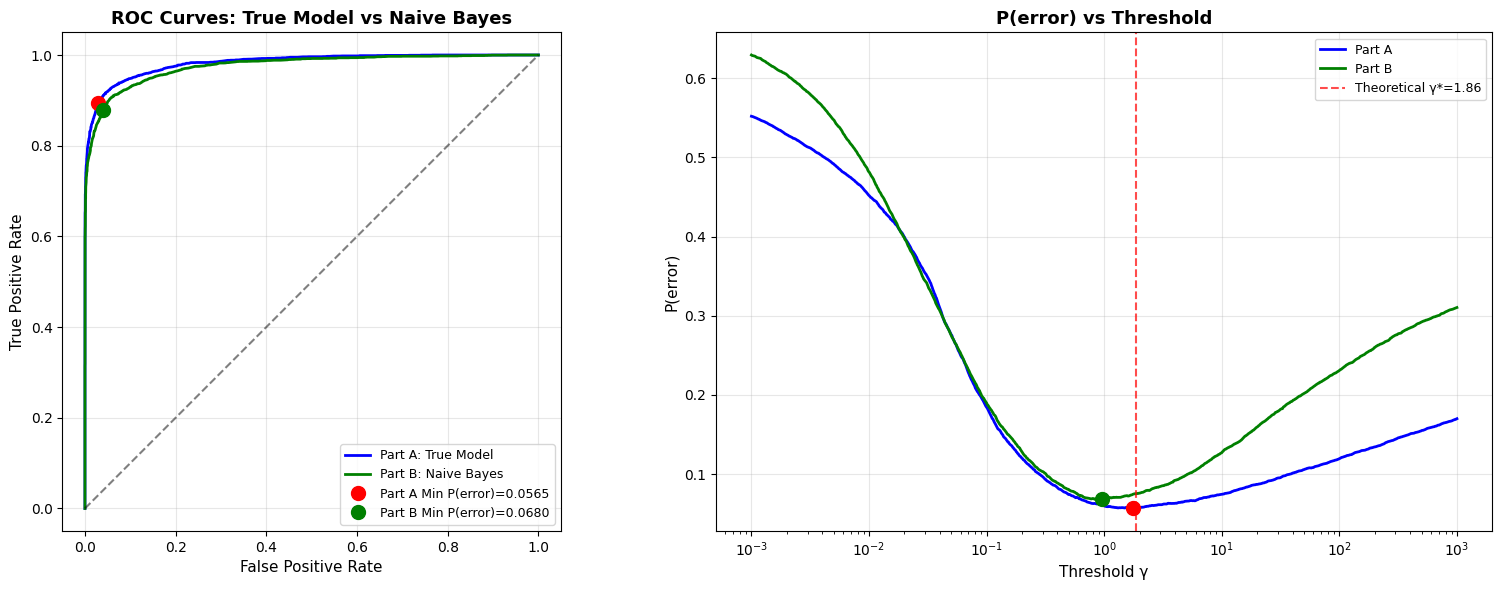

In [12]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Both ROC curves
axes[0].plot(FPR_values, TPR_values, 'b-', linewidth=2, label='Part A: True Model')
axes[0].plot(FPR_values_NB, TPR_values_NB, 'g-', linewidth=2, label='Part B: Naive Bayes')
axes[0].plot(optimal_FPR, optimal_TPR, 'ro', markersize=10, 
             label=f'Part A Min P(error)={min_P_error:.4f}')
axes[0].plot(optimal_FPR_NB, optimal_TPR_NB, 'go', markersize=10, 
             label=f'Part B Min P(error)={min_P_error_NB:.4f}')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontsize=11)
axes[0].set_title('ROC Curves: True Model vs Naive Bayes', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Plot 2: P(error) vs threshold
axes[1].semilogx(gamma_values[1:-1], P_error_values[1:-1], 'b-', linewidth=2, label='Part A')
axes[1].semilogx(gamma_values[1:-1], P_error_values_NB[1:-1], 'g-', linewidth=2, label='Part B')
axes[1].axvline(gamma_optimal, color='r', linestyle='--', alpha=0.7, label=f'Theoretical γ*={gamma_optimal:.2f}')
axes[1].plot(optimal_gamma_empirical, min_P_error, 'ro', markersize=10)
axes[1].plot(optimal_gamma_NB, min_P_error_NB, 'go', markersize=10)
axes[1].set_xlabel('Threshold γ', fontsize=11)
axes[1].set_ylabel('P(error)', fontsize=11)
axes[1].set_title('P(error) vs Threshold', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### Part C - Fisher LDA - Estimate Parameters from Data

In [13]:
X0 = X[labels == 0]
X1 = X[labels == 1]

# Estimate means
m0_est = np.mean(X0, axis=0)
m1_est = np.mean(X1, axis=0)

print("Estimated Class Means:")
print(f"  m0_est: {m0_est}")
print(f"  m1_est: {m1_est}")

# Estimate covariances
C0_est = np.cov(X0, rowvar=False)
C1_est = np.cov(X1, rowvar=False)

print("\nEstimated Covariance Matrices:")
print(f"  C0_est condition number: {np.linalg.cond(C0_est):.2f}")
print(f"  C1_est condition number: {np.linalg.cond(C1_est):.2f}")

Estimated Class Means:
  m0_est: [-0.50948127 -0.47862075 -0.52413126]
  m1_est: [1.00812601 0.97095468 1.00888503]

Estimated Covariance Matrices:
  C0_est condition number: 4.35
  C1_est condition number: 2.71


#### Compute Fisher LDA Projection

In [14]:


# Within-class scatter matrix (using equal weights as specified)
Sw = (C0_est + C1_est) / 2

# Between-class scatter matrix
mean_diff = m1_est - m0_est
Sb = np.outer(mean_diff, mean_diff)

print(f"Within-class scatter Sw:")
print(Sw)
print(f"\nBetween-class scatter Sb:")
print(Sb)
try:
    Sw_inv = np.linalg.inv(Sw)
    w_LDA = Sw_inv @ mean_diff
except np.linalg.LinAlgError:
    print("Warning: Sw is singular, using pseudo-inverse")
    Sw_inv = np.linalg.pinv(Sw)
    w_LDA = Sw_inv @ mean_diff

w_LDA = w_LDA / np.linalg.norm(w_LDA)

print(f"\nFisher LDA projection vector w_LDA:")
print(w_LDA)
print(f"||w_LDA||: {np.linalg.norm(w_LDA):.4f}")

Within-class scatter Sw:
[[ 0.99530544 -0.11021528  0.05203487]
 [-0.11021528  0.97810307 -0.09992562]
 [ 0.05203487 -0.09992562  1.01285992]]

Between-class scatter Sb:
[[2.30313187 2.19988623 2.32651669]
 [2.19988623 2.10126893 2.22222275]
 [2.32651669 2.22222275 2.35013895]]

Fisher LDA projection vector w_LDA:
[0.55886601 0.62288031 0.54743849]
||w_LDA||: 1.0000


#### Project Data and Generate ROC Curve

Projected class 0 mean: -0.8698
Projected class 1 mean: 1.7205
Separation: 2.5903

LDA Minimum P(error): 0.0649
LDA Optimal threshold: τ = 0.3558


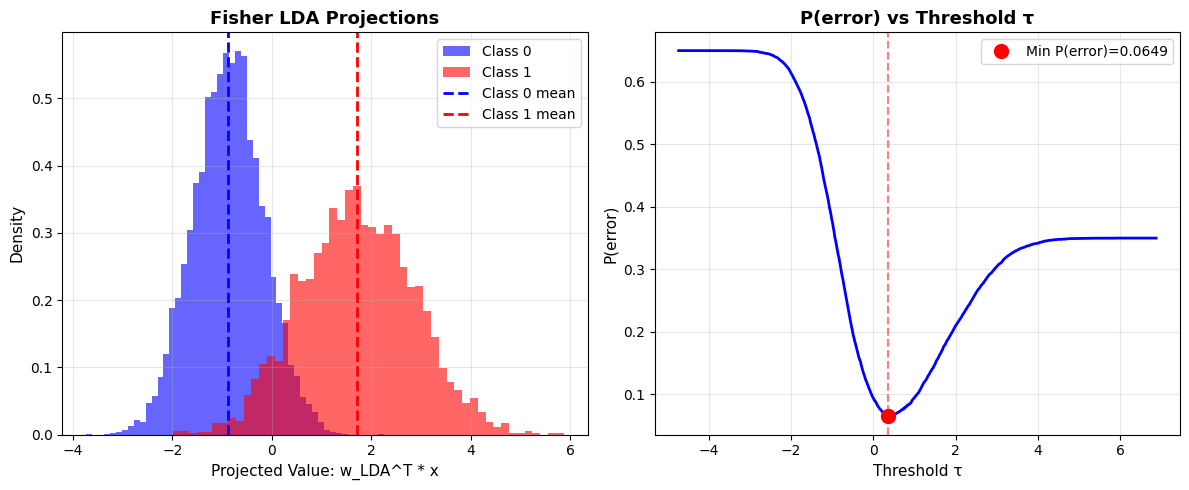

In [15]:

y_projected = X @ w_LDA

y0_mean = m0_est @ w_LDA
y1_mean = m1_est @ w_LDA

print(f"Projected class 0 mean: {y0_mean:.4f}")
print(f"Projected class 1 mean: {y1_mean:.4f}")
print(f"Separation: {abs(y1_mean - y0_mean):.4f}")

# Visualize projections
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_projected[labels == 0], bins=50, alpha=0.6, color='blue', 
         label='Class 0', density=True)
plt.hist(y_projected[labels == 1], bins=50, alpha=0.6, color='red', 
         label='Class 1', density=True)
plt.axvline(y0_mean, color='blue', linestyle='--', linewidth=2, label='Class 0 mean')
plt.axvline(y1_mean, color='red', linestyle='--', linewidth=2, label='Class 1 mean')
plt.xlabel('Projected Value: w_LDA^T * x', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Fisher LDA Projections', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Generate ROC curve for LDA
tau_values = np.linspace(np.min(y_projected) - 1, np.max(y_projected) + 1, 1000)

TPR_values_LDA = []
FPR_values_LDA = []

for tau in tau_values:
    decisions_LDA = (y_projected > tau).astype(int)
    
    TP = np.sum((labels == 1) & (decisions_LDA == 1))
    FP = np.sum((labels == 0) & (decisions_LDA == 1))
    
    TPR_LDA = TP / N1 if N1 > 0 else 0
    FPR_LDA = FP / N0 if N0 > 0 else 0
    
    TPR_values_LDA.append(TPR_LDA)
    FPR_values_LDA.append(FPR_LDA)

TPR_values_LDA = np.array(TPR_values_LDA)
FPR_values_LDA = np.array(FPR_values_LDA)

# Minimum P(error) for LDA
FNR_values_LDA = 1 - TPR_values_LDA
P_error_values_LDA = FPR_values_LDA * p0 + FNR_values_LDA * p1

min_error_idx_LDA = np.argmin(P_error_values_LDA)
min_P_error_LDA = P_error_values_LDA[min_error_idx_LDA]
optimal_tau_LDA = tau_values[min_error_idx_LDA]
optimal_TPR_LDA = TPR_values_LDA[min_error_idx_LDA]
optimal_FPR_LDA = FPR_values_LDA[min_error_idx_LDA]

print(f"\nLDA Minimum P(error): {min_P_error_LDA:.4f}")
print(f"LDA Optimal threshold: τ = {optimal_tau_LDA:.4f}")

plt.subplot(1, 2, 2)
plt.plot(tau_values, P_error_values_LDA, 'b-', linewidth=2)
plt.plot(optimal_tau_LDA, min_P_error_LDA, 'ro', markersize=10, 
         label=f'Min P(error)={min_P_error_LDA:.4f}')
plt.axvline(optimal_tau_LDA, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Threshold τ', fontsize=11)
plt.ylabel('P(error)', fontsize=11)
plt.title('P(error) vs Threshold τ', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Plot ROC Curve for LDA

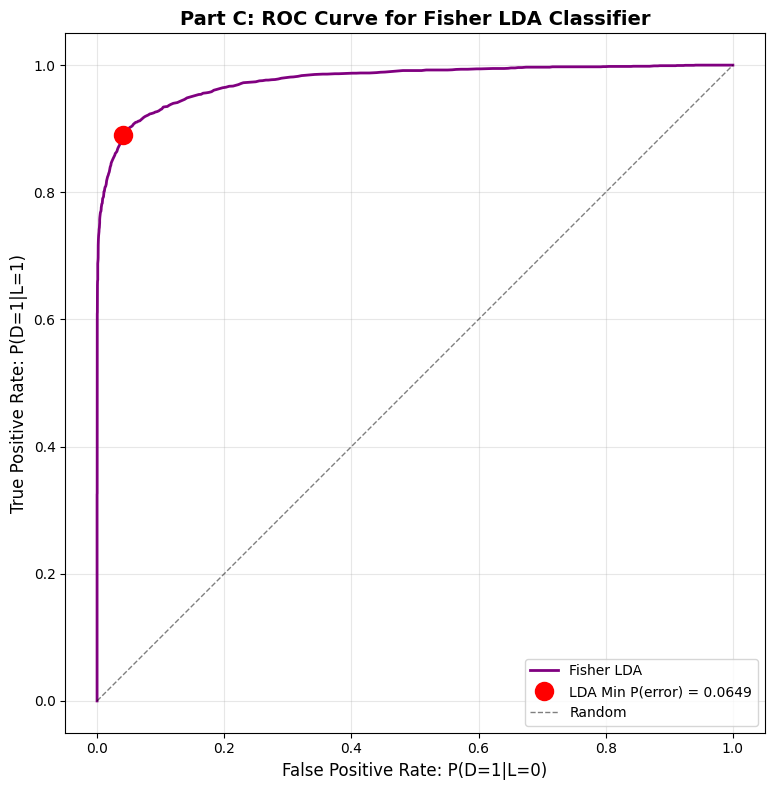

In [16]:
plt.figure(figsize=(10, 8))

plt.plot(FPR_values_LDA, TPR_values_LDA, 'purple', linewidth=2, 
         label='Fisher LDA')
plt.plot(optimal_FPR_LDA, optimal_TPR_LDA, 'ro', markersize=12, 
         markerfacecolor='red', markeredgewidth=2,
         label=f'LDA Min P(error) = {min_P_error_LDA:.4f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random')

plt.xlabel('False Positive Rate: P(D=1|L=0)', fontsize=12)
plt.ylabel('True Positive Rate: P(D=1|L=1)', fontsize=12)
plt.title('Part C: ROC Curve for Fisher LDA Classifier', 
          fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()

#### Comparison - All Three Methods

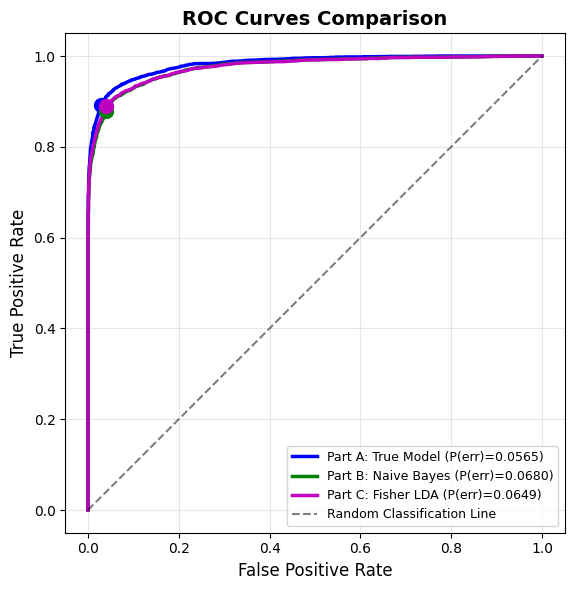

In [24]:
# Create comparison figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot All ROC curves
axes[0].plot(FPR_values, TPR_values, 'b-', linewidth=2.5, 
             label=f'Part A: True Model (P(err)={min_P_error:.4f})')
axes[0].plot(FPR_values_NB, TPR_values_NB, 'g-', linewidth=2.5, 
             label=f'Part B: Naive Bayes (P(err)={min_P_error_NB:.4f})')
axes[0].plot(FPR_values_LDA, TPR_values_LDA, 'm-', linewidth=2.5, 
             label=f'Part C: Fisher LDA (P(err)={min_P_error_LDA:.4f})')

axes[0].plot(optimal_FPR, optimal_TPR, 'bo', markersize=10)
axes[0].plot(optimal_FPR_NB, optimal_TPR_NB, 'go', markersize=10)
axes[0].plot(optimal_FPR_LDA, optimal_TPR_LDA, 'mo', markersize=10)

axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classification Line')

axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

axes[1].remove() 
plt.tight_layout()
plt.show()

#### Summary Table

In [18]:
summary_data = {
    'Classifier': ['Part A: True Model', 'Part B: Naive Bayes', 'Part C: Fisher LDA'],
    'Min P(error)': [min_P_error, min_P_error_NB, min_P_error_LDA],
    'Accuracy': [1-min_P_error, 1-min_P_error_NB, 1-min_P_error_LDA],
    'TPR at optimal': [optimal_TPR, optimal_TPR_NB, optimal_TPR_LDA],
    'FPR at optimal': [optimal_FPR, optimal_FPR_NB, optimal_FPR_LDA],
    'Optimal threshold': [f'{optimal_gamma_empirical:.4f}', 
                          f'{optimal_gamma_NB:.4f}', 
                          f'{optimal_tau_LDA:.4f}']
}

import pandas as pd
df_summary = pd.DataFrame(summary_data)
print("\n", df_summary.to_string(index=False))


          Classifier  Min P(error)  Accuracy  TPR at optimal  FPR at optimal Optimal threshold
 Part A: True Model      0.056498  0.943502        0.893141        0.029381            1.7508
Part B: Naive Bayes      0.068030  0.931970        0.879600        0.039830            0.9528
 Part C: Fisher LDA      0.064921  0.935079        0.889608        0.040436            0.3558
